<a href="https://colab.research.google.com/github/anu04596/DeepLearningTuotorial/blob/main/Day18(Segmentation)ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

U-Net for Image Segmentation

Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

Dummy Dataset

In [18]:
class DummySegmentationDataset(Dataset):
    def __init__(self, train=True):
        self.data = datasets.MNIST(root='./data', train=train, download=True)
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = self.transform(img)

        # Create a binary mask: where pixel > 0.5, it's part of object
        mask = (img > 0.5).float()
        return img, mask


U-Net

In [19]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU()
            )

        self.enc1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.middle = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        m = self.middle(self.pool2(e2))

        d2 = self.up2(m)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        return torch.sigmoid(out)


Training

In [20]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=UNet().to(device)
loss_fn=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)


In [21]:
train_data=DummySegmentationDataset(train=True)
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)

In [23]:
for epoch in range(2):
  for img ,masks  in train_loader:
    img,masks=img.to(device),masks.to(device)
    pred=model(img)
    loss=loss_fn(pred,masks)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 0.0008188505889847875
Epoch: 2, Loss: 0.000876101606991142


Predictions

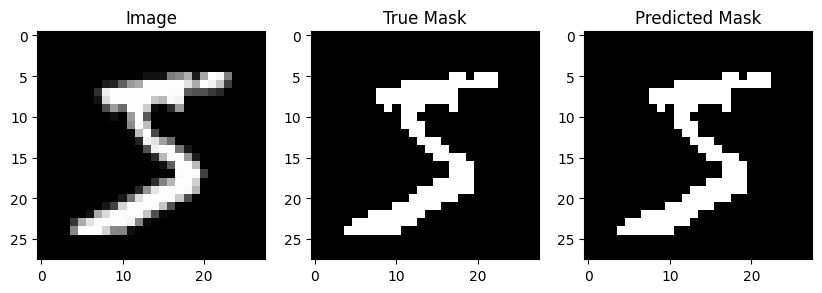

In [24]:
def show_prediction():
    model.eval()
    img, mask = train_data[0]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))[0][0].cpu()

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("True Mask")

    plt.subplot(1,3,3)
    plt.imshow(pred > 0.5, cmap="gray")
    plt.title("Predicted Mask")
    plt.show()

show_prediction()
